# Recommendations with IBM



## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
df_content.shape

(1056, 5)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
df_content['article_id']

0          0
1          1
2          2
3          3
4          4
        ... 
1051    1046
1052    1047
1053    1048
1054    1049
1055    1050
Name: article_id, Length: 1056, dtype: int64

In [5]:
articles_per_user = df.groupby('email')['article_id'].count().reset_index(name='articles').sort_values(by='articles')
articles_per_user

,email,articles
2116,6755c5d49a97e785583f65a92f72bc09459905a9,1
1329,3fbe4978a20ee5ddc07648f2762b808ea18cedd1,1
3160,9c4b5dda1282c94128a7dc778951a313cce8055b,1
1327,3fac88958dc7903b380743597f44a79cf76ea128,1
4857,efdb4c363358224cd99d45053e2dbddf659e25ce,1
...,...,...
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363


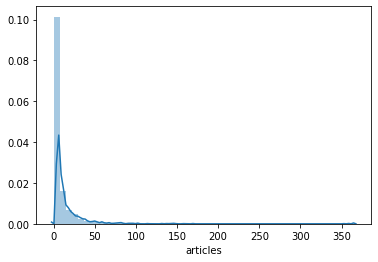

In [6]:
sns.distplot(articles_per_user.articles)


In [7]:
# Fill in the median and maximum number of user_article interactios below
# 50% of individuals interact with ____ number of articles or fewer.
median_val = articles_per_user.articles.median()
print('50% of individuals interact with {} articles or fewer.'.format(median_val))

50% of individuals interact with 3.0 articles or fewer.


In [8]:
# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = articles_per_user.articles.max()
max_views_by_user
print('The maximum number of user-article interactions by any 1 user is: {}'.format(max_views_by_user))

The maximum number of user-article interactions by any 1 user is: 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Find and explore duplicate article
print('{} duplicated rows found in df_content'.format(df_content.duplicated().sum()) )

0 duplicated rows found in df_content


In [10]:
print('{} duplicated article ids found in df_content'.format(df_content.duplicated(['article_id']).sum()) )

5 duplicated article ids found in df_content


In [11]:
# Remove any rows that have the same article_id - only keep the first
keep_first_artid = df_content.drop_duplicates(['article_id'])
keep_first_artid

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
...,...,...,...,...,...
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049


`3.` The following cells are to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [12]:
# unique_articles = df.drop_duplicates(['article_id'])
unique_articles = df.groupby('article_id')['email'].count().reset_index(name='user_count').sort_values(by='user_count')
unique_articles

,article_id,user_count
472,1092.0,1
409,984.0,1
189,417.0,1
570,1237.0,1
567,1233.0,1
...,...,...
652,1364.0,627
697,1427.0,643
701,1431.0,671
625,1330.0,927


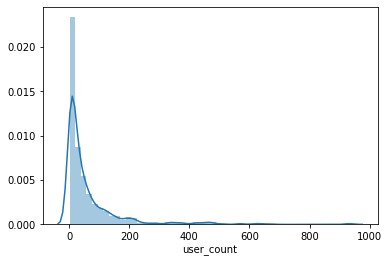

In [13]:
sns.distplot(unique_articles.user_count)

In [14]:
unique_articles.shape[0]

714

In [15]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

In [16]:
print('{} unique articles that have at least one interaction.'.format(unique_articles))
print('{} unique articles on the IBM platform.'.format(total_articles))
print('{} unique users.'.format(unique_users))
print('{} user-article interactions.'.format(user_article_interactions))

714 unique articles that have at least one interaction.
1051 unique articles on the IBM platform.
5148 unique users.
45993 user-article interactions.


`4.` The following cells will find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [17]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [18]:
# map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test 
# t.sol_1_test(sol_1_dict)
print('50% of individuals have {} or fewer interactions.'.format(median_val))
print('The total number of user-article interactions in the dataset is: {}.'.format(user_article_interactions))
print('The maximum number of user-article interactions by any 1 user is: {}.'.format(max_views_by_user))
print('The most viewed article in the dataset was viewed {} times.'.format(max_views))
print('The article_id of the most viewed article is: {}.'.format(most_viewed_article_id))
print('The number of unique articles that have at least 1 rating: {}.'.format(unique_articles))
print('The number of unique users in the dataset is: {}.'.format(unique_users))
print('The number of unique articles on the IBM platform: {}.'.format(total_articles))

50% of individuals have 3.0 or fewer interactions.
The total number of user-article interactions in the dataset is: 45993.
The maximum number of user-article interactions by any 1 user is: 364.
The most viewed article in the dataset was viewed 937 times.
The article_id of the most viewed article is: 1429.0.
The number of unique articles that have at least 1 rating: 714.
The number of unique users in the dataset is: 5148.
The number of unique articles on the IBM platform: 1051.


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [20]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    unique_articles = df.groupby('article_id')['user_id'].count().reset_index(name='id_count').sort_values(by='id_count',ascending=False)
    top_n = unique_articles.iloc[:n, :]['article_id']
    top_articles = df[df['article_id'].isin(top_n)]['title'].drop_duplicates()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    unique_articles = df.groupby('article_id')['user_id'].count().reset_index(name='id_count').sort_values(by='id_count',ascending=False)
    top_articles = unique_articles.iloc[:n, :]['article_id'].astype(str)
 
    return top_articles # Return the top article ids

In [21]:
print(get_top_articles(10))

1           healthcare python streaming application demo
2             use deep learning for image classification
14              apache spark lab, part 1: basic concepts
29     predicting churn with the spss random tree alg...
31               analyze energy consumption in buildings
37                        visualize car data with brunel
42     use xgboost, scikit-learn & ibm watson machine...
56     gosales transactions for logistic regression m...
66           insights from new york car accident reports
154    finding optimal locations of new store using d...
Name: title, dtype: object


In [22]:
print(get_top_article_ids(10))

699    1429.0
625    1330.0
701    1431.0
697    1427.0
652    1364.0
614    1314.0
600    1293.0
526    1170.0
518    1162.0
608    1304.0
Name: article_id, dtype: object


In [23]:
# Test: check the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of the three lists from above
# t.sol_2_test(get_top_articles)
print('top 5 articles by number of interaction:\n {}\n'.format(top_5))
print('top 10 articles by number of interaction:\n {}\n'.format(top_10))
print('top 20 articles by number of interaction:\n {}\n'.format(top_20))

top 5 articles by number of interaction:
 2            use deep learning for image classification
29    predicting churn with the spss random tree alg...
37                       visualize car data with brunel
42    use xgboost, scikit-learn & ibm watson machine...
66          insights from new york car accident reports
Name: title, dtype: object

top 10 articles by number of interaction:
 1           healthcare python streaming application demo
2             use deep learning for image classification
14              apache spark lab, part 1: basic concepts
29     predicting churn with the spss random tree alg...
31               analyze energy consumption in buildings
37                        visualize car data with brunel
42     use xgboost, scikit-learn & ibm watson machine...
56     gosales transactions for logistic regression m...
66           insights from new york car accident reports
154    finding optimal locations of new store using d...
Name: title, dtype: object

top 20 ar

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [24]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [25]:
df_group = df.groupby(['user_id','article_id'])['title'].count().unstack()

# df_group.columns

In [26]:
df_group.notnull().head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [27]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id','article_id'])['title'].count().unstack().notnull().astype(int)  
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
## Tests
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
# print("You have passed our quick tests!  Please proceed!")

In [29]:
s = user_item.dot(user_item.loc[1])
n = s.sort_values(ascending=False)
n.drop(1, inplace=True)
# list(n.index)

In [99]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''

#     # compute similarity of each user to the provided user
#     sim = user_item.dot(user_item.loc[user_id])

#     # sort by similarity
#     sim_sort = sim.sort_values(ascending=False)
    
#     # remove the own user's id
#     sim_sort.drop(user_id,inplace=True)
 
#     # create list of just the ids
#     most_similar_users = list(sim_sort.index)
    
    # compute similarity of each user to the provided user
    similarity = []
    for user in range(1, user_item.shape[0]+1):
        sim = np.dot(user_item.loc[user_id], user_item.loc[user])
        similarity.append((user, sim))

    # sort by similarity
    similarity.sort(key=lambda x: x[1], reverse=True)

    # create list of just the ids
    most_similar_users = [tup[0] for tup in similarity]

    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar

In [100]:
# Do a spot check of the above function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [32]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [33]:
test_ids = [1314.0,1338.0,1276.0]

In [34]:
list(df[df['article_id'].isin(test_ids)]['title'].drop_duplicates())

['healthcare python streaming application demo',
 'ml optimization using cognitive assistant',
 'deploy your python model as a restful api']

In [35]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].drop_duplicates())
    return article_names # Return the article names associated with list of article ids

In [36]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
user_id = 1

In [38]:
ids = user_item.loc[user_id, user_item.loc[user_id]==1]
ids

article_id
43.0      1
109.0     1
151.0     1
268.0     1
310.0     1
329.0     1
346.0     1
390.0     1
494.0     1
525.0     1
585.0     1
626.0     1
668.0     1
732.0     1
768.0     1
910.0     1
968.0     1
981.0     1
1052.0    1
1170.0    1
1183.0    1
1185.0    1
1232.0    1
1293.0    1
1305.0    1
1363.0    1
1368.0    1
1391.0    1
1400.0    1
1406.0    1
1427.0    1
1429.0    1
1430.0    1
1431.0    1
1436.0    1
1439.0    1
Name: 1, dtype: int64

In [39]:
ids.dtype

dtype('int64')

In [40]:
list(ids.index.astype(str))

['43.0',
 '109.0',
 '151.0',
 '268.0',
 '310.0',
 '329.0',
 '346.0',
 '390.0',
 '494.0',
 '525.0',
 '585.0',
 '626.0',
 '668.0',
 '732.0',
 '768.0',
 '910.0',
 '968.0',
 '981.0',
 '1052.0',
 '1170.0',
 '1183.0',
 '1185.0',
 '1232.0',
 '1293.0',
 '1305.0',
 '1363.0',
 '1368.0',
 '1391.0',
 '1400.0',
 '1406.0',
 '1427.0',
 '1429.0',
 '1430.0',
 '1431.0',
 '1436.0',
 '1439.0']

In [41]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    id_list = user_item.loc[user_id, user_item.loc[user_id]==1]
    article_ids = list(id_list.index.astype(str))
    article_names = get_article_names(article_ids,df)
    return article_ids, article_names # return the ids and names

In [42]:
user_id = 1

In [43]:
similar_users = find_similar_users(user_id)
# similar_users

In [44]:
articles_seen = get_user_articles(user_id)
# articles_seen

In [45]:
seen_id = articles_seen[0]

In [46]:
# close_users.map(lambda x: get_user_articles(x))
unseen_articles = pd.Series(similar_users).apply(lambda x: list(set(get_user_articles(x)[0]).difference(set(seen_id))))
# close_articles = pd.Series(close_users).apply(lambda x: [id for id in get_user_articles(x)[0] if id not in seen_id ])

In [47]:
unseen_articles.head()

0                                                   []
1    [409.0, 1428.0, 939.0, 658.0, 1014.0, 1357.0, ...
2    [409.0, 1428.0, 939.0, 658.0, 1014.0, 1357.0, ...
3    [1061.0, 20.0, 1357.0, 1014.0, 1277.0, 1396.0,...
4    [1061.0, 20.0, 1357.0, 1014.0, 1277.0, 1396.0,...
dtype: object

In [48]:
unseen_articles.apply(pd.Series).stack().reset_index(drop=True).drop_duplicates().head()

0     409.0
1    1428.0
2     939.0
3     658.0
4    1014.0
dtype: object

In [49]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # find similar users to specified user_id
    similar_users = find_similar_users(user_id)
    # find articles ids that specified user_id has read
    articles_seen = get_user_articles(user_id)
    seen_ids = articles_seen[0]
    # find article ids that specified user_id has not read but other similar users have read
    #unseen_ids = pd.Series(close_users).apply(lambda x: [id for id in get_user_articles(x)[0] if id not in seen_ids ])
    
    unseen_articles = pd.Series(similar_users).apply(lambda x: list(set(get_user_articles(x)[0]).difference(set(seen_ids))))

    # flatten and drop duplicates of the series to a list
    flatten = unseen_articles.apply(pd.Series).stack().reset_index(drop=True).drop_duplicates()
    # slice the list to m entries
    recs = flatten[:m]
    
    return recs # return your recommendations for this user_id    

In [50]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['using github for project control in dsx',
 'use decision optimization to schedule league games',
 'deep learning from scratch i: computational graphs',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'times world university ranking analysis',
 'ml algorithm != learning machine',
 'automating web analytics through python',
 'data science platforms are on the rise and ibm is leading the way',
 'overlapping co-cluster recommendation algorithm (ocular)',
 '54174    detect potentially malfunctioning sensors in r...\nName: title, dtype: object']

In [51]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."

In [52]:
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
# print("If this is all you see, you passed all of our tests!  Nice job!")

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [53]:
similarity = user_item.dot(user_item.loc[1])
# similarity = find_similar_users(user_id)
similarity

user_id
1       36
2        2
3        6
4        3
5        0
        ..
5145     1
5146     0
5147     0
5148     0
5149     0
Length: 5149, dtype: int64

In [54]:

# sort by similarity
sim_sort = similarity.sort_values(ascending=False)

# remove the own user's id
sim_sort.drop(user_id,inplace=True)
sim_sort

user_id
3933    35
23      17
3782    17
203     15
4459    15
        ..
2920     0
2918     0
2916     0
2911     0
2575     0
Length: 5148, dtype: int64

In [55]:
# create a new dataframe
neighbors_df = sim_sort.reset_index()
neighbors_df

,user_id,0
0,3933,35
1,23,17
2,3782,17
3,203,15
4,4459,15
...,...,...
5143,2920,0
5144,2918,0
5145,2916,0
5146,2911,0


In [56]:
user_article = df.groupby('user_id')['article_id'].count()
pd.merge(neighbors_df, user_article, how='left',on='user_id')

,user_id,0,article_id
0,3933,35,45
1,23,17,364
2,3782,17,363
3,203,15,160
4,4459,15,158
...,...,...,...
5143,2920,0,2
5144,2918,0,1
5145,2916,0,5
5146,2911,0,9


In [57]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of all the other users to current user
    sim = user_item.dot(user_item.loc[user_id])
    
    # sort by similarity
    sim_sort = sim.sort_values(ascending=False)
    
    # remove the own user's id
    sim_sort.drop(user_id,inplace=True)
    
    # create neighbors_df dataframe
    neighbors_df = sim_sort.reset_index()
    
    # find number of article interactions per user(use original df instead of user_item matrix)
    user_article = df.groupby('user_id')['article_id'].count()

    # merge user-article interaction column to neighbors_df
    neighbors_df = pd.merge(neighbors_df, user_article, how='left',on='user_id')
    
    neighbors_df = neighbors_df.rename(columns={'user_id':'neighbor_id', 0:'similarity', 'article_id':'num_interactions'})
    
    
    return neighbors_df

In [58]:
articles_seen = get_user_articles(user_id)
seen_ids = articles_seen[0]
similar_user_df = get_top_sorted_users(user_id).sort_values(by='num_interactions', ascending=False)
similar_user_df

,neighbor_id,similarity,num_interactions
1,23,17,364
2,3782,17,363
22,98,10,170
24,3764,10,169
3,203,15,160
...,...,...,...
2824,1277,0,1
4024,4513,0,1
4022,4520,0,1
1373,2965,1,1


In [59]:
similar_users = similar_user_df['neighbor_id']


In [60]:
def user_user_recs_part2(user_id, m=10):
    # find similar users to specified user_id
    similar_users = get_top_sorted_users(user_id).sort_values(by='num_interactions', ascending=False)['neighbor_id']
    
    # find articles ids that specified user_id has read
    articles_seen = get_user_articles(user_id)
    seen_ids = articles_seen[0]
    
    # find article ids that specified user_id has not read but other similar users have read
    unseen_articles = similar_users.apply(lambda x: list(set(get_user_articles(x)[0]).difference(set(seen_ids))))
    
    # get top articles
    num_top_articles = df.shape[0]
    top_articles = get_top_article_ids(num_top_articles)
    
    unseen_articles_sorted = unseen_articles.apply(lambda x: sort_list(x,top_articles.tolist()))

    
    # flatten and drop duplicates of the series to a list
    flatten = unseen_articles_sorted.apply(pd.Series).stack().reset_index(drop=True).drop_duplicates()
    flatten = flatten.tolist()
   
    # slice the list to m entries
    recs = flatten[:m]
    rec_names = get_article_names(recs)
    return recs, rec_names

In [61]:
unseen_articles = similar_users.apply(lambda x: list(set(get_user_articles(x)[0]).difference(set(seen_ids))))
unseen_articles.head()

1     [409.0, 1428.0, 939.0, 658.0, 1014.0, 1357.0, ...
2     [409.0, 1428.0, 939.0, 658.0, 1014.0, 1357.0, ...
22    [409.0, 130.0, 939.0, 658.0, 20.0, 1176.0, 57....
24    [409.0, 130.0, 939.0, 658.0, 20.0, 1176.0, 57....
3     [1061.0, 20.0, 1357.0, 1014.0, 1277.0, 1396.0,...
Name: neighbor_id, dtype: object

In [62]:
top_articles = get_top_article_ids(df.shape[0])
top_articles.head()

699    1429.0
625    1330.0
701    1431.0
697    1427.0
652    1364.0
Name: article_id, dtype: object

In [66]:
def sort_list(list1,list2):
    sorted_list = sorted(list1, key=lambda x: list2.index(x) )
    return sorted_list

In [67]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # find similar users to specified user_id
    similar_users = get_top_sorted_users(user_id).sort_values(by='num_interactions', ascending=False)['neighbor_id']
    
    # find articles ids that specified user_id has read
    articles_seen = get_user_articles(user_id)
    seen_ids = articles_seen[0]
    
    # find article ids that specified user_id has not read but other similar users have read
    unseen_articles = similar_users.apply(lambda x: list(set(get_user_articles(x)[0]).difference(set(seen_ids))))
    
    # get top articles
    num_top_articles = df.shape[0]
    top_articles = get_top_article_ids(num_top_articles)
    
    unseen_articles_sorted = unseen_articles.apply(lambda x: sort_list(x,top_articles.tolist()))

    
    # flatten and drop duplicates of the series to a list
    flatten = unseen_articles_sorted.apply(pd.Series).stack().reset_index(drop=True).drop_duplicates()
   
    # slice the list to m entries
    recs = flatten[:m]
    rec_names = get_article_names(recs)
    return recs, rec_names

In [68]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
0    1429.0
1    1330.0
2    1431.0
3    1427.0
4    1364.0
5    1314.0
6    1293.0
7    1170.0
8    1162.0
9    1304.0
dtype: object

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']


`5.` Use functions from above to correctly fill in the solutions to the dictionary below. 

In [69]:
get_top_sorted_users(20).head(10)

,neighbor_id,similarity,num_interactions
0,40,2,78
1,113,2,68
2,4932,2,76
3,5123,2,13
4,419,2,16
5,196,2,15
6,2164,2,8
7,2354,2,10
8,4883,2,67
9,204,2,97


In [70]:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
3,4459,33,158
4,203,33,160
5,98,29,170
6,3764,29,169
7,3697,29,145
8,49,29,147
9,242,25,148


In [71]:
### Tests with a dictionary of results

user1_most_sim = 3933# Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [72]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

# t.sol_5_test(sol_5_dict)
print('The user that is most similar to user 1: {}'.format(user1_most_sim))
print('The user that is most similar to user 131: {}'.format(user131_10th_sim))

The user that is most similar to user 1: 3933
The user that is most similar to user 131: 242


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For a new user, since we don't have any previous data about the user's reading preference, there is no way to use collaborative filtering to give recommendation.This is called the 'cold start'problem. To solve this problem, we can use rank based recommendation or content based recommendation.


`7.` The following code provides the top 10 recommended articles I would provide for the a new user below. 

In [73]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

new_user_recs

699    1429.0
625    1330.0
701    1431.0
697    1427.0
652    1364.0
614    1314.0
600    1293.0
526    1170.0
518    1162.0
608    1304.0
Name: article_id, dtype: object

In [74]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

# print("That's right!  Nice job!")

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, I will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` Run the cells to get things set up.

In [75]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [76]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, I use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD.

In [77]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**There are no missing values in user_item_matrix so we can perform SVD instead of FunkSVD. .**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

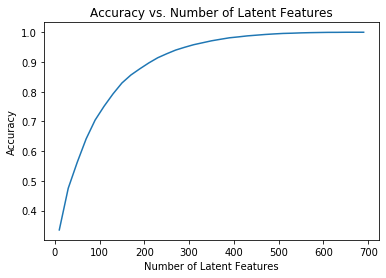

In [78]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [122]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # create user_item matrix of both the train and test sets
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # user ids of train and test sets
    train_idx = user_item_train.index
    test_idx = user_item_test.index
    
    # article ids of train and test sets
    train_arts = user_item_train.columns
    test_arts = user_item_test.columns
    
    # common user ids and article ids in train and test sets
    common_idx = np.intersect1d(test_idx, np.array(user_item_train.index))
    common_arts = np.intersect1d(test_arts, np.array(user_item_train.columns))
    
    return user_item_train, user_item_test, train_idx, test_idx, train_arts, test_arts, common_idx, common_arts

user_item_train, user_item_test, train_idx, test_idx, train_arts, test_arts, common_idx, common_arts = create_test_and_train_user_item(df_train, df_test)

In [123]:
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [109]:
# users we can make predictions for in the test set
common_idx.shape[0]

20

In [110]:
# articles that we can make predictions for in the test set
common_arts.shape[0]

574

In [111]:
# users in the test set we art not able to make predictions for because of the cold start problem
len(test_idx)-common_idx.shape[0]

662

In [112]:
# articles in the test set that are not able to make predictions because of the cold start problem
len(test_arts) - user_item_test.shape[1]

0

In [85]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

In [115]:
sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

# t.sol_4_test(sol_4_dict)


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [127]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [88]:
#see how well we can use the training decomposition to predict on test data

In [128]:
u_test = u_train[user_item_train.index.isin(test_idx), :]
u_test.shape

(20, 4487)

In [129]:
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
vt_test.shape

(714, 574)

In [131]:
user_item_test = user_item_test.loc[common_idx]
user_item_test.shape

(20, 574)

In [91]:
s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:10]), u_train[:, :10], vt_train[:10, :]
s_test_lat, u_test_lat, vt_test_lat = s_train_lat, u_test[:, :10], vt_test[:10, :]   

In [92]:
s_train_lat.shape, u_train_lat.shape, vt_train_lat.shape

((10, 10), (4487, 10), (10, 714))

In [93]:
s_test_lat.shape,u_test_lat.shape, vt_test_lat.shape

((10, 10), (20, 10), (10, 574))

In [94]:
user_item_train_est = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
user_item_train_est.shape


(4487, 714)

In [95]:
user_item_test_est = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat)) 
user_item_test_est.shape


(20, 574)

In [96]:
diffs_train = np.subtract(user_item_train, user_item_train_est)
diffs_test = np.subtract(user_item_test.loc[common_idx,common_arts], user_item_test_est)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

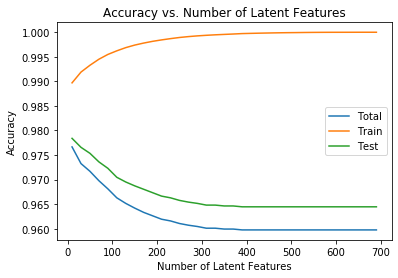

In [135]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []
total_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]    
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_est = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat)) 
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test.loc[common_idx,:], user_item_test_est)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    total_errs.append(1 - ((np.sum(user_item_test_est)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))

# plot accuracy chart
plt.plot(num_latent_feats, total_errs, label='Total');    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0] * user_item_test.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend()
plt.show()

7. Results

From the plot above we can see that as the number of latent features increases, the acuracy of prediction on training data increases but the accuracy on the test data decreases. This suggests that the performance of our model works better in training data but worse in test data due to overfitting. One possible optomization I could try in the future is using fewer latent features. The reason is that the user-item matrix is quite sparse and small in size that we don't need as many latent features.   

### <a class="anchor" id="conclusions">Part V: Conclusions</a>

In this notebook I implemented three types of recommendation techniques: rank based recommendations, user-user based collaborative filtering and matrix factorization. 


- Rank based recommendation is implemented by ranking the articles by the number of user interactions. Articles that are read by the most users are ranked as top. This type of recommendation is easy to implement, but since it only concerns the number of readings, it is not personalized.

- User-user collaborative filtering is implemented by create a user-item matrix which records if a user has any interaction with an article. Then, for each user with any other user, dot product is performed to calculate how similar each two users are. Next, find articles that have been read by other most similar users but have not been read by the user we want to make recommendations to,  pick a certain number of articles with top interaciton, and recommend to this user. This type of recommendation is highly personalized, but one draw back is the 'cold start problem', meaning that we have no previous data to based on to recommend to a new user. To solve this problem, content based recommendation or rank based recommendation could be used. 

- Matrix Factorization is implemented by using singular value decomposition (SVD) technique. Because our dataset has no missing value, simple SVD would do. Otherwise, FunkSVD should be used with data containing missing value. I split the user-item matrix into three matrices: U matrix represents how users feel about latent features; S matrix is a diagonal matrix that provides weights in descending order with how much each latent feature matters towards reconstruction the original user-item matrix; V matrix provides how items(articles in this case) relate to each latent features. By reconstruction the user-item matrix by split it into train and test sets, and then calculating therir dot products, I got a predicted matrix. The accuracy of the prediction is represented by calculating the difference of the predicted matrix and  the original uer-item matrix. Then I plotted the accuracy of training and test sets according to the number of latent features. 

- With respect to which recommendation works the best, an A/B test could be performed in the future to determine what suits business more. 
  - For example, to determine which works the best between collaborative filtering and matrix factorization , The null hypothesis could be that the two recommendations work the same. The alternative hypothesis could be that they are different(one is better or worse than the other)
  
  - The unit of diversion could be account-based, which means we split users into two similar sized groups by their user IDs because our data shows that all users have their user IDs. 
  - Then we show A group collaborative filtering recommendations and B group recommendations using matrix factorization. The invariant metric 

In [98]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0